In [ ]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU, BatchNormalization
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt

import pickle
from tensorflow.keras import optimizers

import tensorflow as tf

%matplotlib inline

In [ ]:
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam 
from keras.applications import VGG16, VGG19
from keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd drive/My Drive/AA_PROJ_2

/content/drive/.shortcut-targets-by-id/1H2HZrq04aWM2rHry2TNwQDsUieDFENJg/AA_PROJ_2


<h2>Load file locations. </h2>

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
pkl_trainx=["Pickled_Data/Final/DB/np_db_x_train1.pickle",
            "Pickled_Data/Final/DB/np_db_x_train2.pickle"]

pkl_testx=["Pickled_Data/Final/DB/np_db_x_test1.pickle",
            "Pickled_Data/Final/DB/np_db_x_test2.pickle"]

pkl_validx=["Pickled_Data/Final/DB/np_db_x_valid1.pickle",
            "Pickled_Data/Final/DB/np_db_x_valid2.pickle"]

pkl_y=["Pickled_Data/Final/WF/y.pickle", "Pickled_Data/Final/SP/y.pickle"]

dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

In [ ]:
def generate_batch_train(batch_size):
  lcount=0
  fcount=0
  nloads=[3,5]

  while True:
    filex=pkl_trainx[fcount]
    filey=pkl_y[fcount]
    if lcount==0:
      pkl_filex=open(filex,"rb")
      pkl_filey=open(filey,"rb")

    xtrain=pickle.load(pkl_filex)
    ytrain=pickle.load(pkl_filey)
    xtrain=np.expand_dims(xtrain,axis=-1)

    lcount+=1
    if lcount==nloads[fcount]:
      lcount=0
      fcount=(fcount+1)%len(pkl_trainx)

    for b in range(0,xtrain.shape[0],batch_size):
      yield (xtrain[b:(b+batch_size)],tf.keras.utils.to_categorical(np.vectorize(dict_genres.get)(ytrain[b:(b+batch_size)]), num_classes=8))

In [ ]:
def generate_batch_valid(batch_size):
  lcount=0
  nloads=2

  while True:
    filex=pkl_validx[0]
    filey=pkl_y[0]

    if lcount==0:
      pkl_filex=open(filex,"rb")
      pkl_filey=open(filey,"rb")
    
    xvalid=pickle.load(pkl_filex)
    yvalid=pickle.load(pkl_filey)
    xvalid=np.expand_dims(xvalid,axis=-1)
    lcount+=1
    
    if lcount==nloads:
      lcount=0
      pkl_filex.close()
      pkl_filey.close()

    for b in range(0,xvalid.shape[0],batch_size):
      yield (xvalid[b:(b+batch_size)],tf.keras.utils.to_categorical(np.vectorize(dict_genres.get)(yvalid[b:(b+batch_size)]), num_classes=8))

<h3>Construct model</h3>

<h3>Network model configuration</h3>

In [ ]:
dict_genres={'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7 }
num_classes=len(dict_genres)

nb_filters1=64 
nb_filters2=32 
nb_filters3=32
nb_filters4=16
nb_filters5=16
pool_size_1= (2,2) 
pool_size_2= (2,2)
pool_size_3 = (2,2)
ksize = (3,1)
dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
EPOCH_COUNT = 50
L2_regularization = 0.001

In [ ]:
def construct_model(model_input,kernel_size=(3,3),filters=[64,32,16],pool_size=(2,2)):
  x=model_input
  for filt in filters:
    x=Conv2D(filters=filt,kernel_size=kernel_size,strides=1,
             padding= 'valid', activation='relu')(x)
    x=BatchNormalization()(x)
    x=MaxPooling2D(pool_size)(x)
    x=Dropout(0.4)(x)

  x=Flatten()(x)
  output=Dense(num_classes,activation='softmax')(x)
  model=Model(model_input,output)
  model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.00025),metrics=['accuracy'])
  print(model.summary())
  return model

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 388, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 126, 388, 64)      256       
_________________________________________________________________
batch_normalization_16 (Batc (None, 126, 388, 64)      256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 194, 64)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 63, 194, 64)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 194, 32)       6176      
_________________________________________________________________
batch_normalization_17 (Batc (None, 61, 194, 32)       128 

ValueError: ignored

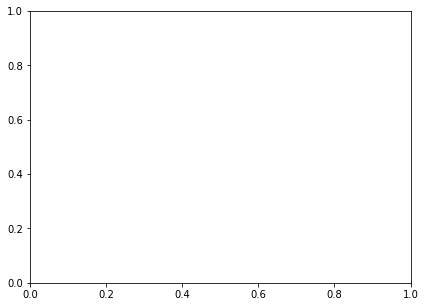

In [ ]:
#construct model
filters=[[64,32,16],[32,32,16],[64,32],[32,16],[32,32]]
nfrequency=128
nframes=388
input_shape=(nfrequency,nframes,1)
model_input=Input(input_shape,name='input')
for f in filters:
  model=construct_model(model_input,filters=f)
  history=model.fit_generator(
      generate_batch_train(9), 
      steps_per_epoch=(990*8) // 9,
      epochs=30,
      validation_data=generate_batch_valid(9),
      validation_steps=(2000) // 9,
  )
  plot_acc_loss(history, 30)
  

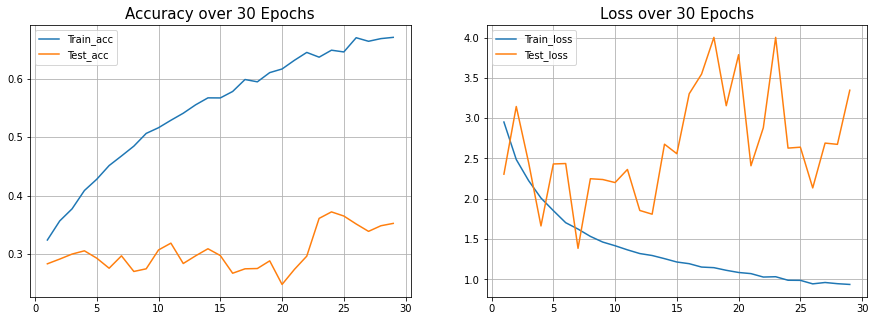

In [ ]:
plot_acc_loss(history, 30)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 388, 1)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 126, 388, 32)      128       
_________________________________________________________________
batch_normalization_19 (Batc (None, 126, 388, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 194, 32)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 63, 194, 32)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 61, 194, 32)       3104      
_________________________________________________________________
batch_normalization_20 (Batc (None, 61, 194, 32)       128 

ValueError: ignored

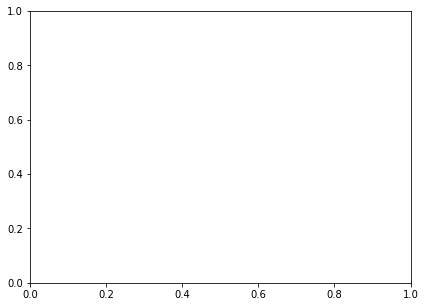

In [ ]:
#construct model
filters=[[32,32,16],[64,32],[32,16],[32,32]]
nfrequency=128
nframes=388
input_shape=(nfrequency,nframes,1)
model_input=Input(input_shape,name='input')
for f in filters:
  model=construct_model(model_input,filters=f)
  history=model.fit_generator(
      generate_batch_train(9), 
      steps_per_epoch=(990*8) // 9,
      epochs=20,
      validation_data=generate_batch_valid(9),
      validation_steps=(2000) // 9,
  )
  plot_acc_loss(history, 20)

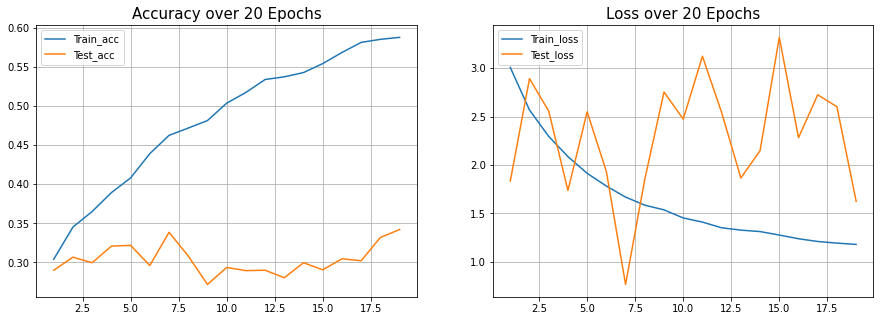

In [ ]:
plot_acc_loss(history, 20)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 388, 1)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 126, 388, 64)      256       
_________________________________________________________________
batch_normalization_22 (Batc (None, 126, 388, 64)      256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 194, 64)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 63, 194, 64)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 61, 194, 32)       6176      
_________________________________________________________________
batch_normalization_23 (Batc (None, 61, 194, 32)       128 

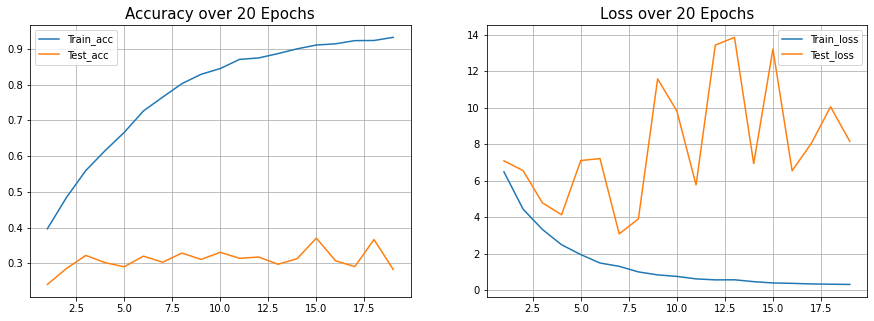

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 388, 1)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 126, 388, 32)      128       
_________________________________________________________________
batch_normalization_24 (Batc (None, 126, 388, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 194, 32)       0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 63, 194, 32)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 61, 194, 16)       1552      
_________________________________________________________________
batch_normalization_25 (Batc (None, 61, 194, 16)       64  

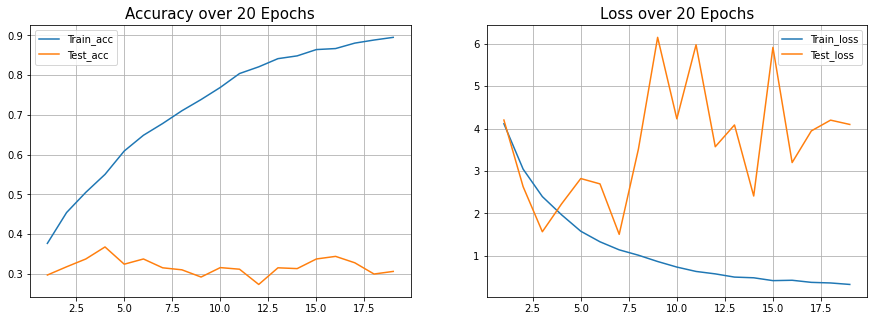

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 388, 1)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 126, 388, 32)      128       
_________________________________________________________________
batch_normalization_26 (Batc (None, 126, 388, 32)      128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 63, 194, 32)       0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 63, 194, 32)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 61, 194, 32)       3104      
_________________________________________________________________
batch_normalization_27 (Batc (None, 61, 194, 32)       128 

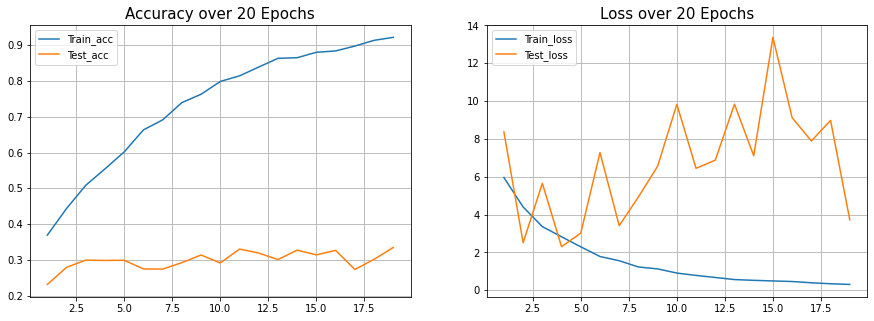

In [ ]:
#construct model
filters=[[64,32],[32,16],[32,32]]
nfrequency=128
nframes=388
input_shape=(nfrequency,nframes,1)
model_input=Input(input_shape,name='input')
for f in filters:
  model=construct_model(model_input,filters=f)
  history=model.fit_generator(
      generate_batch_train(9), 
      steps_per_epoch=(990*8) // 9,
      epochs=20,
      validation_data=generate_batch_valid(9),
      validation_steps=(2000) // 9,
  )
  plot_acc_loss(history, 20)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 388, 1)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 126, 388, 64)      256       
_________________________________________________________________
batch_normalization_28 (Batc (None, 126, 388, 64)      256       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 63, 194, 64)       0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 63, 194, 64)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 61, 194, 64)       12352     
_________________________________________________________________
batch_normalization_29 (Batc (None, 61, 194, 64)       256 

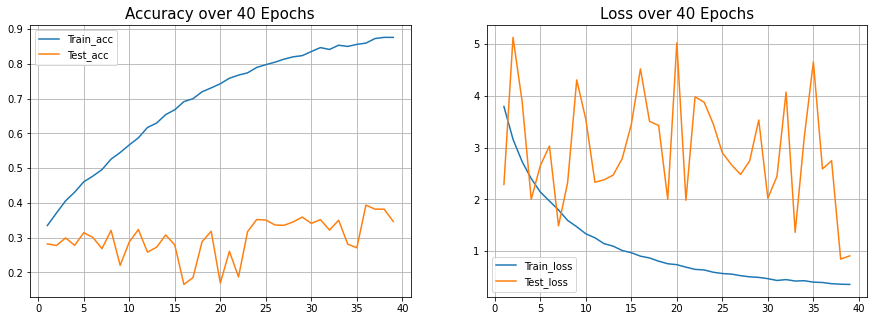

In [ ]:
#construct model
filters=[[64,64,32]]
nfrequency=128
nframes=388
input_shape=(nfrequency,nframes,1)
model_input=Input(input_shape,name='input')
for f in filters:
  model=construct_model(model_input,filters=f)
  history=model.fit_generator(
      generate_batch_train(9), 
      steps_per_epoch=(990*8) // 9,
      epochs=40,
      validation_data=generate_batch_valid(9),
      validation_steps=(2000) // 9,
  )
  plot_acc_loss(history, 40)